# Amazon Fine Food Analysis

In [1]:
import pandas as pd
import numpy as np
import string
import spacy
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./datas/Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
len(data)

568454

In [4]:
data = data[:10000]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


In [6]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,5000.50000,1.573500,2.014900,4.134500,1.294359e+09
std,2886.89568,5.230634,5.807551,1.327172,4.769699e+07
min,1.00000,0.000000,0.000000,1.000000,9.617184e+08
25%,2500.75000,0.000000,0.000000,4.000000,1.268762e+09
50%,5000.50000,0.000000,1.000000,5.000000,1.307837e+09
75%,7500.25000,2.000000,2.000000,5.000000,1.329955e+09
max,10000.00000,187.000000,216.000000,5.000000,1.351210e+09


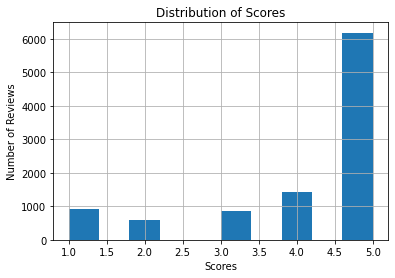

In [7]:
data['Score'].hist()
plt.title("Distribution of Scores")
plt.xlabel("Scores")
plt.ylabel("Number of Reviews");

In [8]:
new_df = data[['Text','Score']]
new_df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [9]:
new_df['Score'] = np.where(new_df['Score'] > 3, 1, 0)

new_df.drop_duplicates(inplace=True)
new_df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [10]:
new_df = new_df.groupby('Score').sample(n = 1000, random_state = 1)

In [11]:
new_df = new_df.sample(frac = 1).reset_index(drop = True)

In [12]:
new_df['Text'] = new_df['Text'].str.lower()

In [13]:
new_df.head()

,Text,Score
0,quite disappointed. the pills don't last that ...,0
1,my wife and i both thought this is a nice cup ...,1
2,what a lovely tea this is! the rose petals are...,1
3,i love the strong coffee flavor of this for ba...,1
4,that's all i can say. yum at a great price! i ...,1


-----
# Processing Data Before EDA


## Lemmatization and Stopwords Removal

In [14]:
# Loading the model
nlp = spacy.load("en_core_web_sm")

# Lemmatization with stopwords removal
new_df['Lemmatized_Text'] = new_df['Text'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [15]:
new_df.head()

,Text,Score,Lemmatized_Text
0,quite disappointed. the pills don't last that ...,0,disappointed . pill long ( wear try pill ) foo...
1,my wife and i both thought this is a nice cup ...,1,wife think nice cup coffee . bag - way valve a...
2,what a lovely tea this is! the rose petals are...,1,"lovely tea ! rose petal abundant mix , brew po..."
3,i love the strong coffee flavor of this for ba...,1,"love strong coffee flavor bake , nearly 20 yea..."
4,that's all i can say. yum at a great price! i ...,1,. yum great price ! find size local grocery aw...


#### Removing HTML tags, punctuations and numerical vals

In [16]:
new_df['Lemmatized_Text'] = new_df['Lemmatized_Text'].replace(to_replace ='<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});',
                                                             value= ' ', regex=True)

####  Punctuation removal

In [17]:
new_df['Lemmatized_Text'] = new_df['Lemmatized_Text'].apply(lambda x : re.sub('[%s]' %re.escape(string.punctuation),'',x))

#### Number removal

In [18]:
new_df['Lemmatized_Text'] = new_df['Lemmatized_Text'].apply(lambda x : re.sub('\w*\d\w*','', x))

In [19]:
new_df['Lemmatized_Text'][:5]

0    disappointed  pill long  wear try pill  food i...
1    wife think nice cup coffee  bag  way valve air...
2    lovely tea  rose petal abundant mix  brew pot ...
3    love strong coffee flavor bake  nearly  year c...
4     yum great price  find size local grocery awes...
Name: Lemmatized_Text, dtype: object

In [20]:
new_df['Text'] = [i for i in new_df['Lemmatized_Text'].str.split()]
new_df['Text'] = new_df['Text'].apply(' '.join)
new_df['Text']

0       disappointed pill long wear try pill food item...
1       wife think nice cup coffee bag way valve air a...
2       lovely tea rose petal abundant mix brew pot te...
3       love strong coffee flavor bake nearly year cho...
4         yum great price find size local grocery awesome
                              ...                        
1995    like salt vinegar chip salty eat actual pinche...
1996    different experience supplement mother milk mo...
1997    okay complete coffee nut know grow bean run pr...
1998    plant arrive great condition fully green head ...
1999    try chip whim shop costco stop carry chip look...
Name: Text, Length: 2000, dtype: object

In [21]:
new_df.drop('Lemmatized_Text', axis=1, inplace=True)
new_df.head()

,Text,Score
0,disappointed pill long wear try pill food item...,0
1,wife think nice cup coffee bag way valve air a...,1
2,lovely tea rose petal abundant mix brew pot te...,1
3,love strong coffee flavor bake nearly year cho...,1
4,yum great price find size local grocery awesome,1


----
### Most frequent words

    Creating a document term matrix, which holds the frequency of words present in the corpus. TF-IDF vectorizer will be used to make this matrix. In case of positive words which are more than one word length, n-grams will be used.

In [22]:
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(2,3))
data_p = tfidf.fit_transform(new_df[new_df['Score'] == 1]['Text']) # positive reviews
dtm_p = pd.DataFrame(data_p.toarray(), columns=tfidf.get_feature_names())
dtm_p.index = new_df[new_df['Score'] == 1].index
dtm_p

,abate steep,abate steep prefer,abbott laboratories,abbott laboratories similac,ability fully,ability fully enjoy,ability mix,ability mix baked,ability obtain,ability obtain quality,...,zoo promotion,zoo promotion buy,zucchini relish,zucchini relish cookbooks,zucchini take,zucchini take minute,zuke thing,zuke thing hotdog,zuke treat,zuke treat acceptation
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.096781,0.096781,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Top 10 positive reviews

['highly recommend', 'gluten free', 'taste good', 'taste like', 'grocery store', 'taste great', 'hot cocoa', 'cup coffee', 'great product', 'hard find']


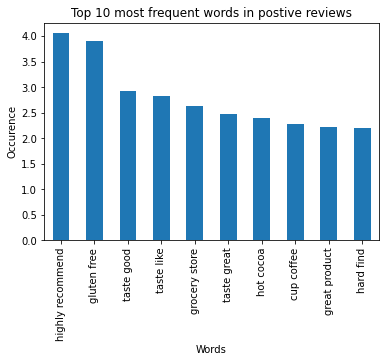

In [23]:
dtm_p.sum().nlargest(10).plot.bar()
plt.title("Top 10 most frequent words in postive reviews")
plt.xlabel("Words")
plt.ylabel("Occurence")
print(list(dtm_p.sum().nlargest(10).index))

### Top 10 negative reviews

In [24]:
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(4,4))
data_n = tfidf.fit_transform(new_df[new_df['Score'] == 0]['Text']) # negative reviews
dtm_n = pd.DataFrame(data_n.toarray(), columns=tfidf.get_feature_names())
dtm_n.index = new_df[new_df['Score'] == 0].index
dtm_n

,aa sumatra columbian supremo,ability able ship good,able close seal lid,able different cake cake,able drink tea taste,able eat hot pepper,able expose little wide,able find sausage ring,able find shed light,able ignor texture long,...,zip lock baggie stay,zip lock think like,zipfizz provide necessary potassium,zipfizz zipfizz provide necessary,zipper didnt seal maybe,zippy carbonation place fridge,zoom find einsteinian logic,zoom matter fact arm,zucchini update review today,zupas pathetic imitator grandeur
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


['dog care real nutty', 'high fructose corn syrup', 'arrive day stale eat', 'bit disappointed flavor want', 'day stale eat bag', 'disappointed flavor want expect', 'cancel order cancel problem', 'cancel problem positive note', 'container badly dented jan', 'content container badly dented']


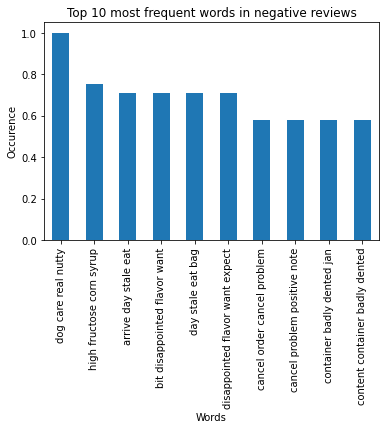

In [25]:
dtm_n.sum().nlargest(10).plot.bar()
plt.title("Top 10 most frequent words in negative reviews")
plt.xlabel("Words")
plt.ylabel("Occurence")
print(list(dtm_n.sum().nlargest(10).index))

In [26]:
top_positive_words = list(dtm_p.sum().nlargest(10).index)
print(top_positive_words)

for top_words in top_positive_words:
    positive_sentences_with_topwords = []
    
    for pos_sent in new_df[new_df['Score'] == 1]['Text']:
        if top_words in pos_sent:
            positive_sentences_with_topwords.append(pos_sent.replace(top_words,''))
            
    df = pd.DataFrame(positive_sentences_with_topwords,columns=['Txt'])
    
    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,3))
    data_pcw = tfidf.fit_transform(df['Txt'])
    dtm_pcw = pd.DataFrame(data_pcw.toarray(), columns=tfidf.get_feature_names())
    dtm_pcw.index = df.index
    
    lst = list(dtm_pcw.sum().nlargest(15).index)
    print(top_words,' : ', lst,'\n')

['highly recommend', 'gluten free', 'taste good', 'taste like', 'grocery store', 'taste great', 'hot cocoa', 'cup coffee', 'great product', 'hard find']
highly recommend  :  ['goat milk', 'vanilla flavor', 'good coffee', 'blueberry vanilla', 'excellent service', 'use seller', 'love product', 'soy dairy', 'flavor coffee', 'french vanilla', 'christmas gift', 'absolutely delicious', 'absolutely delicious try', 'delicious try', 'delicious try meat'] 

gluten free  :  ['taste good', 'prefer pancake', 'rice cake', 'pancake mix', 'mix market', 'betty crocker', 'mix taste', 'actually surprised', 'actually surprised good', 'good muffin', 'good muffin taste', 'muffin taste', 'muffin taste reorder', 'reorder case', 'surprised good'] 

taste good  :  ['gluten free', 'rice cake', 'chip healthy', 'chip healthy regular', 'healthy regular', 'healthy regular chip', 'regular chip', 'try chip', 'try chip healthy', 'instant coffee', 'bad eat', 'bad eat course', 'course lot', 'course lot great', 'cup every

#### Character count distribution in Text column

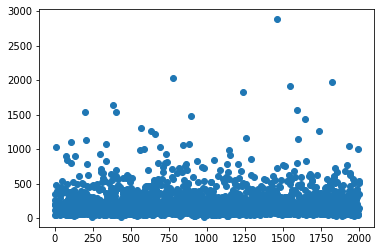

In [27]:
arr_length = [i for i in range(2000)]

char_count = [len(i) for i in new_df['Text']]
plt.scatter(arr_length,char_count);

In [28]:
np.percentile(char_count,98.48)

916.2279999999994

Majority of the sentences have a character count `less than 916 characters` (98.48% of time).

### Word Cloud for Positive Sentences

In [29]:
def generate_word_cloud(text):
    
    stop_words = nlp.Defaults.stop_words
    
    wordcloud = WordCloud(stopwords=stop_words,background_color='white',collocation_threshold=3)
    wordcloud.generate(text)
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud,interpolation='bilinear')
    return plt.show()

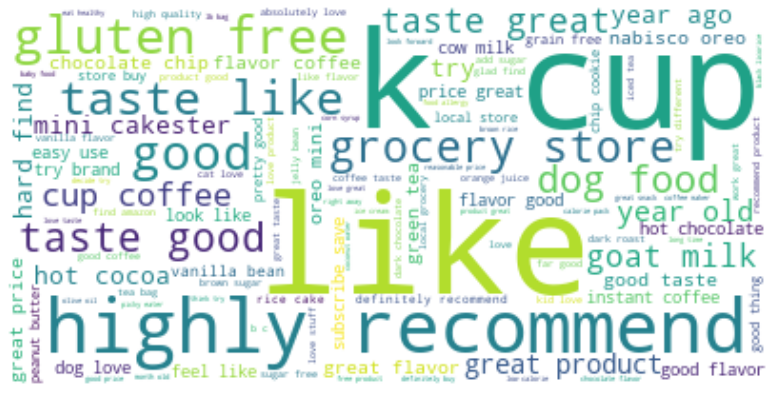

In [30]:
positive_sentences = new_df.loc[new_df.Score == 1].Text
text = " ".join(review for review in positive_sentences.astype(str))

generate_word_cloud(text)

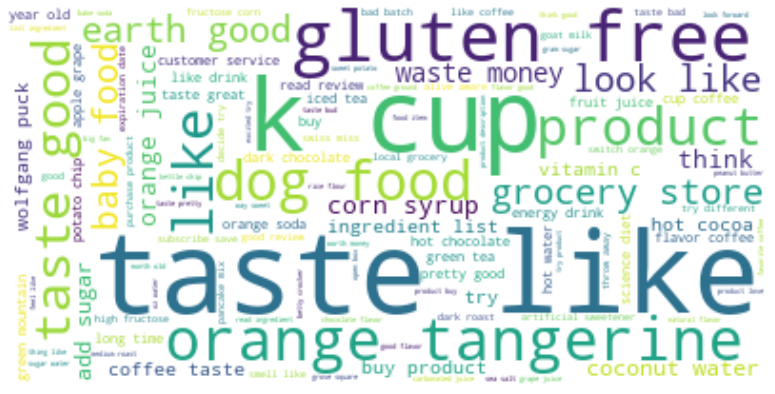

In [31]:
negative_sentences = new_df.loc[new_df.Score == 0].Text
text = " ".join(review for review in negative_sentences.astype(str))

generate_word_cloud(text)

----
# Training and Testing

In [32]:
def get_vector(x):
    
    """
    A function to convert sentence into vector using spaCy's word2vec vectorizer.
    """
    
    doc = nlp(x)
    vect = doc.vector
    
    return vect

In [33]:
new_df['Vector'] = new_df['Text'].apply(lambda x: get_vector(x))
new_df.head()

,Text,Score,Vector
0,disappointed pill long wear try pill food item...,0,"[0.13139975, 0.8026615, 0.40601152, -0.3943690..."
1,wife think nice cup coffee bag way valve air a...,1,"[0.38660103, 0.33903986, 0.41844746, -0.142518..."
2,lovely tea rose petal abundant mix brew pot te...,1,"[0.16054408, 0.9602579, 0.29721957, -0.2319164..."
3,love strong coffee flavor bake nearly year cho...,1,"[0.27508327, 0.8391287, 0.28057477, -0.0871015..."
4,yum great price find size local grocery awesome,1,"[-0.08612104, 0.6148981, 0.20196562, 0.1025304..."


In [34]:
X = new_df['Vector'].to_numpy()
X = X.reshape(-1,1)
X.shape

(2000, 1)

In [35]:
X = np.concatenate(np.concatenate(X,axis=0),axis=0).reshape(-1,300)
X.shape

(640, 300)

# Split the Data

In [42]:
y = new_df.Score[:640]

# splitting the data into training and testing with 75:25 split ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [45]:
print("Shape of training data X: ",X_train.shape)
print("Shape of testing data X: ",X_test.shape)

Shape of training data X:  (480, 300)
Shape of testing data X:  (160, 300)


## Training a Logistic Regression Model

In [46]:
# load model and set parameters
model = LogisticRegression(C=1, solver='liblinear', random_state=1)

# fitting the model
model.fit(X_train,y_train)

LogisticRegression(C=1, random_state=1, solver='liblinear')

In [48]:
print("Training Accuracy: ",model.score(X_train,y_train))
print("Testing Accuracy: ",model.score(X_test, y_test))

Training Accuracy:  0.85625
Testing Accuracy:  0.49375


In [50]:
y_prediction = model.predict(X_test)

print("Precision score on test data: ",precision_score(y_test,y_prediction))
print("Recall score on test data: ",recall_score(y_test,y_prediction))
print("F1 score on test data: ",f1_score(y_test,y_prediction))

Precision score on test data:  0.5119047619047619
Recall score on test data:  0.5180722891566265
F1 score on test data:  0.5149700598802395


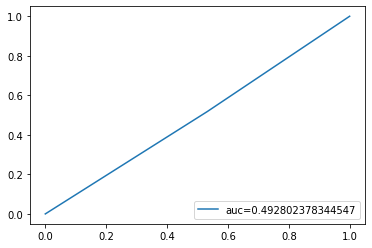

In [51]:
fpr, tpr, _ = roc_curve(y_test,  y_prediction)
auc = roc_auc_score(y_test, y_prediction)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [53]:
confusion_matrix(y_test, y_prediction) # confusion matrix

array([[36, 41],
       [40, 43]], dtype=int64)